![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import re

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
4150,id_4150,Lisbon,"['European', 'Portuguese', 'Mediterranean', 'G...",531.0,$$ - $$$,125.0,"[['Hidden treasure of Lisbon', 'Keep it a secr...",/Restaurant_Review-g189158-d4755823-Reviews-Re...,d4755823,0,0.0
44507,id_2694,Brussels,"['Brazilian', 'Mediterranean', 'European', 'Po...",2682.0,$$ - $$$,NaN,"[[], []]",/Restaurant_Review-g188644-d11956134-Reviews-O...,d11956134,1,3.0
17434,id_917,Oslo,"['Bar', 'Pub']",918.0,$$ - $$$,61.0,"[['Try the fish & chips', 'About as Irish as R...",/Restaurant_Review-g190479-d3386778-Reviews-Ga...,d3386778,1,3.5
41506,id_1021,Berlin,NaN,1023.0,NaN,21.0,"[['Best in the district', 'Curry Wursts rock!'...",/Restaurant_Review-g187323-d11854799-Reviews-C...,d11854799,1,4.5
22710,id_1573,Stockholm,NaN,1576.0,NaN,6.0,"[[], []]",/Restaurant_Review-g189852-d5953246-Reviews-Cr...,d5953246,1,3.5


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [15]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [16]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

#### Заполним пропуски в стобце 'Number of Reviews', используя информацию из столбца Ranking, так как скорее всего ранг ресторана формируется за счет отзывов посетителей. И, можно предположить, что эти параметры взаимосвязаны. Для начала посмотрим как распределены рестораны по рангу.

In [17]:
data['Ranking'].value_counts()

93.0       22
72.0       21
491.0      21
842.0      21
1013.0     20
           ..
8027.0      1
10415.0     1
14621.0     1
11766.0     1
10585.0     1
Name: Ranking, Length: 12975, dtype: int64

#### Как можно заметить, ресторанов с высоким рангом намного меньше, чем с низким. Разделим рестораны по рангу на 3 группы (высокий, средний, низкий)

In [18]:
data['Ranking'].value_counts(bins=3)

(-15.443999999999999, 5482.0]    38260
(5482.0, 10963.0]                 8051
(10963.0, 16444.0]                3689
Name: Ranking, dtype: int64

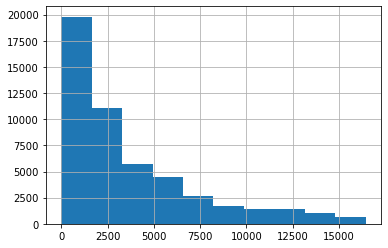

In [19]:
data['Ranking'].hist()

#### Напишем функцию для нахождения наиболее часто встречающегося признака в списке

In [20]:
def most_frequent(List):
    counter = 0
    n = List[0]     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            n = i 
    return n

#### Теперь найдем моду в каждой подгруппе ресторанов с различным рангом

In [21]:
rank1=[]
rank2=[]
rank3=[]
for rank in data['Ranking']:
    if ((rank>-15.5) and (rank<=5482)):
        rank1.append(rank)
    elif ((rank>5482) and (rank<=10963)):
        rank2.append(rank)
    elif ((rank>10963) and (rank<=16444)):
        rank3.append(rank)
        
print(most_frequent(rank1))    
print(most_frequent(rank2)) 
print(most_frequent(rank3))


93.0
5860.0
12709.0


#### Итак, нашли наиболее часто встречающиеся ранги ресторанов в трех группах. Теперь найдем среднее значение Number of Reviews со значениями Ranking, найденными на предыдущем шаге

In [22]:
df_rank1=pd.DataFrame(data.query('Ranking==93'))
df_rank2=pd.DataFrame(data.query('Ranking==5860'))
df_rank3=pd.DataFrame(data.query('Ranking==12709'))


In [23]:
df_rank1['Number of Reviews'].mean()

526.4090909090909

In [24]:
df_rank2['Number of Reviews'].mean()

46.166666666666664

In [25]:
df_rank3['Number of Reviews'].mean()

49.0

#### Теперь заполним пропуски значениями, полученными на предыдущем шаге, при этом учитывая, к какому рангу относится ресторан

In [26]:
for rank in data['Ranking']:
    if ((rank>-15.5) and (rank<=5482)):
        data['Number of Reviews'].fillna(df_rank1['Number of Reviews'].mean(), inplace=True)
    elif ((rank>5482) and (rank<=10963)):
        data['Number of Reviews'].fillna(df_rank2['Number of Reviews'].mean(), inplace=True)
    elif ((rank>10963) and (rank<=16444)):
        data['Number of Reviews'].fillna(df_rank3['Number of Reviews'].mean(), inplace=True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine Style            38410 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Price Range              32639 non-null  object 
 5   Number of Reviews        50000 non-null  float64
 6   Reviews                  49998 non-null  object 
 7   URL_TA                   50000 non-null  object 
 8   ID_TA                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
dtypes: float64(3), int64(1), object(7), uint8(1)
memory usage: 4.2+ MB


#### Пропусков в столбце Reviews немного, поэтому заменим эти пропуски нулями. Это не должно сильно повлиять на результат.

In [28]:
data['Reviews'].fillna(0, inplace=True)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine Style            38410 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Price Range              32639 non-null  object 
 5   Number of Reviews        50000 non-null  float64
 6   Reviews                  50000 non-null  object 
 7   URL_TA                   50000 non-null  object 
 8   ID_TA                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
dtypes: float64(3), int64(1), object(7), uint8(1)
memory usage: 4.2+ MB


#### Теперь необходимо обработать столбцы Cuisine Style и Price Range. Так как эти параметры имеют тип object,  то просто так заменить эти значения какими-то статистиками не получится. Рассмотрим подробнее столбцы Cuisine Style и Price Range

In [30]:
data['Cuisine Style'].value_counts()

['Italian']                                                                                                                        1332
['French']                                                                                                                         1019
['Spanish']                                                                                                                         860
['French', 'European']                                                                                                              503
['Cafe']                                                                                                                            500
                                                                                                                                   ... 
['French', 'Mediterranean', 'European', 'Delicatessen']                                                                               1
['Belgian', 'Bar', 'European', 'Pub', 'French', 

In [31]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

#### Пропусков в данных столбцах достаточно много, удалить не получится. Посмотрим, в каких городах имеются пропуски в столбце Price Range.

In [32]:
data['Price Range'].fillna(0, inplace=True)
s=0
for i in data['Price Range']:
    if (i==0):
        s+=1
print(s)

17361


#### Для удобства заменим название столбца

In [33]:
data.rename(columns={'Price Range': 'Price_Range', }, inplace=True)

#### Рассмотрим непосредственно рестораны, в которых пропуск в ценовой категории

In [34]:
df_price_range=pd.DataFrame(data.query('Price_Range == 0'))

In [35]:
df_price_range.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17361 entries, 7 to 49997
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            17361 non-null  object 
 1   City                     17361 non-null  object 
 2   Cuisine Style            5771 non-null   object 
 3   Ranking                  17361 non-null  float64
 4   Price_Range              17361 non-null  object 
 5   Number of Reviews        17361 non-null  float64
 6   Reviews                  17361 non-null  object 
 7   URL_TA                   17361 non-null  object 
 8   ID_TA                    17361 non-null  object 
 9   sample                   17361 non-null  int64  
 10  Rating                   17361 non-null  float64
 11  Number_of_Reviews_isNAN  17361 non-null  uint8  
dtypes: float64(3), int64(1), object(7), uint8(1)
memory usage: 1.6+ MB


In [36]:
df_price_range['City'].value_counts()

London        1997
Paris         1987
Madrid        1691
Berlin        1257
Barcelona     1138
Milan         1074
Prague         699
Hamburg        661
Vienna         577
Lisbon         562
Lyon           529
Rome           529
Stockholm      479
Brussels       456
Munich         419
Warsaw         363
Budapest       322
Amsterdam      320
Copenhagen     277
Athens         244
Zurich         213
Bratislava     204
Dublin         202
Oporto         201
Geneva         188
Krakow         177
Helsinki       158
Oslo           154
Edinburgh      145
Luxembourg      74
Ljubljana       64
Name: City, dtype: int64

In [37]:
df_price_range['Ranking'].value_counts()

1178.0     10
1438.0      9
1947.0      8
995.0       8
1245.0      8
           ..
6830.0      1
4156.0      1
6877.0      1
5479.0      1
12268.0     1
Name: Ranking, Length: 9321, dtype: int64

#### Поделим рестораны по рангу на 3 категории

In [38]:
df_price_range['Ranking'].value_counts(bins=3)

(-1.43, 5491.333]        11498
(5491.333, 10967.667]     3904
(10967.667, 16444.0]      1959
Name: Ranking, dtype: int64

#### Теперь посмотрим в каких городах самые дорогие рестораны. Для этого в основном датафрейме data заменим значения по ценовой категории на 1 - самые недорогие, 2 - средняя цена, 3 - самые дорогие. Пропуски оставим пока нулями

In [39]:
data.loc[data['Price_Range'] == '$', 'Price_Range'] = 1
data.loc[data['Price_Range'] == '$$ - $$$', 'Price_Range'] = 2
data.loc[data['Price_Range'] == '$$$$', 'Price_Range'] = 3

In [40]:
data['Price_Range'].value_counts()

2    23041
0    17361
1     7816
3     1782
Name: Price_Range, dtype: int64

In [41]:
df_city1=pd.DataFrame(data.query('Price_Range == 1'))
df_city2=pd.DataFrame(data.query('Price_Range == 2'))
df_city3=pd.DataFrame(data.query('Price_Range == 3'))

In [42]:
df_city1['City'].value_counts()

London        1269
Paris          729
Rome           645
Barcelona      592
Milan          523
Madrid         441
Berlin         428
Lisbon         337
Prague         332
Budapest       225
Amsterdam      217
Edinburgh      193
Athens         180
Brussels       170
Oporto         164
Vienna         162
Dublin         151
Krakow         144
Warsaw         137
Munich         118
Hamburg        104
Lyon            95
Copenhagen      91
Stockholm       64
Helsinki        61
Zurich          60
Oslo            52
Ljubljana       47
Bratislava      38
Geneva          32
Luxembourg      15
Name: City, dtype: int64

In [43]:
df_city1['Number of Reviews'].mean()

91.69178607983623

In [44]:
df_city2['City'].value_counts()

London        3651
Paris         3109
Barcelona     1561
Madrid        1560
Rome          1317
Milan          990
Berlin         964
Amsterdam      794
Prague         743
Lisbon         704
Vienna         665
Brussels       639
Munich         554
Lyon           469
Dublin         466
Stockholm      458
Budapest       446
Copenhagen     414
Warsaw         393
Edinburgh      388
Hamburg        388
Zurich         365
Athens         328
Geneva         318
Oporto         259
Oslo           250
Helsinki       237
Krakow         220
Luxembourg     163
Bratislava     124
Ljubljana      104
Name: City, dtype: int64

In [45]:
df_city2['Number of Reviews'].mean()

185.5779263052819

In [46]:
df_city3['City'].value_counts()

Paris         283
London        276
Madrid        121
Milan         107
Barcelona     104
Rome           98
Berlin         56
Munich         54
Geneva         52
Brussels       49
Zurich         47
Lisbon         44
Prague         42
Amsterdam      41
Vienna         39
Copenhagen     37
Lyon           33
Hamburg        33
Stockholm      32
Oslo           32
Warsaw         32
Budapest       28
Athens         24
Helsinki       19
Edinburgh      19
Oporto         18
Dublin         17
Bratislava     14
Krakow         13
Luxembourg     11
Ljubljana       7
Name: City, dtype: int64

In [47]:
df_city3['Number of Reviews'].mean()

367.19584736251403

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine Style            38410 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Price_Range              50000 non-null  object 
 5   Number of Reviews        50000 non-null  float64
 6   Reviews                  50000 non-null  object 
 7   URL_TA                   50000 non-null  object 
 8   ID_TA                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
dtypes: float64(3), int64(1), object(7), uint8(1)
memory usage: 4.2+ MB


In [49]:
def to_numeric(columns):
    s = pd.Series(data[columns])
    pd.to_numeric(s)
    data[columns] = pd.to_numeric(data[columns])

In [50]:
for col in ['Price_Range']:
    to_numeric(col)

#### Как можно заметить, цены в ресторане зависят от количетсва отзывов

#### Заполним пропуски в соответствии с количеством отзывов о ресторане и рангом ресторана. 

In [51]:
data['Number of Reviews'].value_counts(bins=3)

(-7.659000000000001, 3221.333]    49945
(3221.333, 6440.667]                 50
(6440.667, 9660.0]                    5
Name: Number of Reviews, dtype: int64

In [52]:
for i in data['Number of Reviews']:
    if (i<=3221.333):
        data.loc[data['Price_Range'] == 0, 'Price_Range'] = 1
    elif ((i>3221.333) and (i<=6440.667)):
        data.loc[data['Price_Range'] == 0, 'Price_Range'] = 2
    elif (i>6440.667):
        data.loc[data['Price_Range'] == 0, 'Price_Range'] = 3

In [53]:
data['Price_Range'].value_counts()

1    25177
2    23041
3     1782
Name: Price_Range, dtype: int64

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine Style            38410 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Price_Range              50000 non-null  int64  
 5   Number of Reviews        50000 non-null  float64
 6   Reviews                  50000 non-null  object 
 7   URL_TA                   50000 non-null  object 
 8   ID_TA                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
dtypes: float64(3), int64(2), object(6), uint8(1)
memory usage: 4.2+ MB


#### Рассмотрим столбец Cuisine Stule

In [55]:
data['Cuisine Style'].value_counts()

['Italian']                                                                                                                        1332
['French']                                                                                                                         1019
['Spanish']                                                                                                                         860
['French', 'European']                                                                                                              503
['Cafe']                                                                                                                            500
                                                                                                                                   ... 
['French', 'Mediterranean', 'European', 'Delicatessen']                                                                               1
['Belgian', 'Bar', 'European', 'Pub', 'French', 

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine Style            38410 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Price_Range              50000 non-null  int64  
 5   Number of Reviews        50000 non-null  float64
 6   Reviews                  50000 non-null  object 
 7   URL_TA                   50000 non-null  object 
 8   ID_TA                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
dtypes: float64(3), int64(2), object(6), uint8(1)
memory usage: 4.2+ MB


#### Пока оставим пропуски в данном столбце, пересмотрим данный столбец в процессе обработки

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [57]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price_Range                    3
Number of Reviews           1573
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [58]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [59]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price_Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price_Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
16417,id_6962,"['Mediterranean', 'Spanish', 'European', 'Vege...",6963.0,1,50.0,"[['Not much to write about.', 'Not a good expe...",/Restaurant_Review-g187497-d10109262-Reviews-L...,d10109262,1,3.0,...,0,0,0,0,0,0,0,0,0,0
21377,id_1098,"['Chinese', 'Asian', 'Healthy']",1100.0,1,8.0,[['Buffet full of asian flavours with a vegan....,/Restaurant_Review-g189541-d12715546-Reviews-V...,d12715546,1,4.0,...,0,0,0,0,0,0,0,0,0,0
42829,id_3997,NaN,3999.0,1,9.0,"[[], []]",/Restaurant_Review-g187323-d8768691-Reviews-Ko...,d8768691,1,4.5,...,0,0,0,0,0,0,0,0,0,0
4324,id_4324,"['Mediterranean', 'Spanish', 'Delicatessen', '...",1416.0,3,63.0,"[['Cool place....', 'Terrible service'], ['10/...",/Restaurant_Review-g187514-d10797678-Reviews-B...,d10797678,0,0.0,...,0,0,0,0,0,0,0,0,0,0
26854,id_4691,"['Bar', 'Cafe', 'Mediterranean', 'Italian']",4692.0,1,89.0,"[['Great little bite to eat', 'A lot of fun'],...",/Restaurant_Review-g187791-d4451222-Reviews-Ne...,d4451222,1,4.0,...,0,0,0,0,1,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [61]:
data['Price_Range'].value_counts()

1    25177
2    23041
3     1782
Name: Price_Range, dtype: int64

#### Столбец Price_Range обработан при заполении NaN

#### Посмотрим снова на данные

In [62]:
df1 = data
df1

,Restaurant_id,Cuisine Style,Ranking,Price_Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,0,0,0,0,0,0,0,0,0,0
49996,id_6340,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,0,0,1,0,0,0,0,0,0,0
49997,id_1649,"['Japanese', 'Sushi']",1652.0,1,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,0,0,0,0,0,1,0,0,0,0
49998,id_640,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,0,0,0,0,0,0,0,1,0,0


#### Рассмотрим столбец Restaurant_id. В данном случае в значениях уберем приставку id_ и сделаем все значения числовыми

In [63]:
df1.Restaurant_id=df1.Restaurant_id.apply(lambda x: x.replace('id_', ""))

In [64]:
df1

,Restaurant_id,Cuisine Style,Ranking,Price_Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,0,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,499,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,0,0,0,0,0,0,0,0,0,0
49996,6340,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,0,0,1,0,0,0,0,0,0,0
49997,1649,"['Japanese', 'Sushi']",1652.0,1,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,0,0,0,0,0,1,0,0,0,0
49998,640,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,0,0,0,0,0,0,0,1,0,0


In [65]:
m=df1['Restaurant_id'].value_counts()
m[:40]

871     19
227     19
436     19
633     19
585     18
71      18
321     18
430     18
344     18
534     18
245     17
561     17
69      17
107     17
589     17
792     17
200     17
335     17
152     17
482     17
1076    17
367     17
79      17
920     17
206     17
167     17
256     17
364     17
54      16
479     16
359     16
86      16
995     16
1009    16
330     16
779     16
105     16
150     16
85      16
1079    16
Name: Restaurant_id, dtype: int64

In [66]:
to_numeric('Restaurant_id')


#### Как можно увидеть, id ресторанов повторяются. Возможно повторяются данные в датасете. Проверим это

In [67]:
#repdf=pd.DataFrame(df1.query('Restaurant_id == 660'))
df1.query('Restaurant_id == 85')

,Restaurant_id,Cuisine Style,Ranking,Price_Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
85,85,"['Italian', 'Pizza', 'Vegetarian Friendly']",14038.0,1,44.0,"[['Umm not my favourite', 'Great value for mon...",/Restaurant_Review-g186338-d9857169-Reviews-Fr...,d9857169,0,0.0,...,0,0,0,0,0,0,0,0,0,0
10527,85,"['Spanish', 'Vegetarian Friendly', 'Vegan Opti...",86.0,2,2186.0,"[['EXCELENT!', 'Amazing tapas'], ['01/07/2018'...",/Restaurant_Review-g187497-d697571-Reviews-El_...,d697571,1,4.5,...,0,0,0,0,0,0,0,0,0,0
10546,85,"['Thai', 'Vegetarian Friendly', 'Vegan Options...",86.0,2,441.0,"[['Excellent Thai Food', 'Best Thai food in Pa...",/Restaurant_Review-g187147-d783281-Reviews-Tha...,d783281,1,4.5,...,0,0,1,0,0,0,0,0,0,0
11185,85,"['French', 'Vegetarian Friendly', 'Gluten Free...",86.0,3,166.0,"[['Superb dining', 'Nice food in the city cent...",/Restaurant_Review-g274707-d694876-Reviews-Res...,d694876,1,4.5,...,0,0,0,1,0,0,0,0,0,0
15879,85,"['Mediterranean', 'European', 'Greek', 'Vegeta...",86.0,2,147.0,"[['Great food and environment', ""I've been sev...",/Restaurant_Review-g1136493-d4993004-Reviews-P...,d4993004,1,4.5,...,0,0,0,0,0,0,0,0,0,0
16769,85,"['Mediterranean', 'European', 'Spanish']",86.0,3,137.0,"[['Absolutely amazing', 'Food heaven'], ['10/3...",/Restaurant_Review-g190479-d6989823-Reviews-Bo...,d6989823,1,4.5,...,0,1,0,0,0,0,0,0,0,0
22824,85,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",86.0,2,320.0,"[['Good Simple Food Served Well', 'Good food, ...",/Restaurant_Review-g274873-d5003127-Reviews-Ar...,d5003127,1,3.5,...,0,0,0,0,0,0,0,0,0,0
26463,85,"['Mediterranean', 'French', 'European', 'Veget...",86.0,2,1002.0,"[['Superb bistro', 'A little bit French in the...",/Restaurant_Review-g186525-d734186-Reviews-La_...,d734186,1,4.5,...,0,0,0,0,0,0,0,0,0,0
27839,85,"['International', 'Fusion', 'Central European'...",86.0,2,150.0,"[['Excellent food', 'Polish Cuisine in Tastefu...",/Restaurant_Review-g274772-d10371753-Reviews-G...,d10371753,1,4.5,...,0,0,0,0,0,0,0,0,0,0
29021,85,"['International', 'Mediterranean', 'European',...",86.0,3,273.0,"[['Good vibes', 'Great Restaurant'], ['02/21/2...",/Restaurant_Review-g189158-d12274149-Reviews-J...,d12274149,1,4.5,...,0,0,0,0,0,0,0,0,0,0


#### Нет, одинаковый id имеют разные рестораны. Но можно увидеть, что значения id ресторана практически совпадают со значением ранка. Так как нам понадобится столбец Restaurant_id, то удалим стобец Ranking

In [68]:
#repdf=pd.DataFrame(df1.query('Restaurant_id == 660'))
df1 = df1.drop('Ranking', 1)

In [69]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  int64  
 1   Cuisine Style            38410 non-null  object 
 2   Price_Range              50000 non-null  int64  
 3   Number of Reviews        50000 non-null  float64
 4   Reviews                  50000 non-null  object 
 5   URL_TA                   50000 non-null  object 
 6   ID_TA                    50000 non-null  object 
 7   sample                   50000 non-null  int64  
 8   Rating                   50000 non-null  float64
 9   Number_of_Reviews_isNAN  50000 non-null  uint8  
 10  City_Amsterdam           50000 non-null  uint8  
 11  City_Athens              50000 non-null  uint8  
 12  City_Barcelona           50000 non-null  uint8  
 13  City_Berlin              50000 non-null  uint8  
 14  City_Bratislava       

In [70]:
df1

,Restaurant_id,Cuisine Style,Price_Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,0,"['Bar', 'Pub']",2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,"['European', 'Scandinavian', 'Gluten Free Opti...",2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,['Vegetarian Friendly'],2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,"['Italian', 'Mediterranean', 'European', 'Vege...",3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,"['Italian', 'Mediterranean', 'European', 'Seaf...",3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,499,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,0,...,0,0,0,0,0,0,0,0,0,0
49996,6340,"['French', 'American', 'Bar', 'European', 'Veg...",2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,0,...,0,0,1,0,0,0,0,0,0,0
49997,1649,"['Japanese', 'Sushi']",1,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,0,...,0,0,0,0,0,1,0,0,0,0
49998,640,"['Polish', 'European', 'Eastern European', 'Ce...",2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,0,...,0,0,0,0,0,0,0,1,0,0


#### Рассмотрим столбец Reviews. 

In [71]:
df1['Reviews'].value_counts()

[[], []]                                                                                                             8112
0                                                                                                                       2
[['Excellent food food', 'Fantastic sushi served tapas style'], ['09/07/2016', '02/21/2016']]                           2
[['Good restaurant for one meal.', 'Olive Garden Restaurant Warsaw. Food very...'], ['04/20/2015', '07/15/2013']]       2
[['Good service and clean', 'Chinese fusion cuisine - ok to try if you...'], ['11/21/2017', '05/23/2017']]              2
                                                                                                                     ... 
[['Solid British pub with good beer and good...', 'Pre Show Meal'], ['11/06/2017', '07/12/2017']]                       1
[['Carefully watch your bar tab and double ch...', 'Best Indian food I tasted!'], ['07/25/2016', '06/13/2016']]         1
[['Best chilli sauce eve

In [72]:
def str_to_list(string):
    symbol_list = ['[',']',"'"]
    
    if string != None:
        for i in symbol_list:
            string = str(string).replace(i,'')
        return string.split(', ')
    return string

In [73]:
df1['Cuisine Style'] = df1['Cuisine Style'].fillna('other_cuisines').apply(str_to_list)

In [74]:
cuisines_list = []
for c_list in df1['Cuisine Style']:
    for cus in c_list:
        cuisines_list.append(cus)
cus_freq = pd.Series(cuisines_list).value_counts()
cus_list = cus_freq.index
cus_list

Index(['Vegetarian Friendly', 'European', 'other_cuisines', 'Mediterranean',
       'Italian', 'Vegan Options', 'Gluten Free Options', 'Bar', 'French',
       'Asian',
       ...
       'Caucasian', 'Azerbaijani', 'Welsh', 'Fujian', 'Polynesian', 'Yunnan',
       'Salvadoran', 'Burmese', 'Latvian', 'Xinjiang'],
      dtype='object', length=126)

In [75]:
for i in cus_list:
    df1.insert(33,i,0)
df1

,Restaurant_id,Cuisine Style,Price_Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,...,Vegetarian Friendly,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,0,"[Bar, Pub]",2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,"[European, Scandinavian, Gluten Free Options, ...",2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,[Vegetarian Friendly],2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,"[Italian, Mediterranean, European, Vegetarian ...",3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,"[Italian, Mediterranean, European, Seafood, Ve...",3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,499,"[Italian, Vegetarian Friendly, Vegan Options, ...",2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,0,...,0,0,0,0,0,0,0,0,0,0
49996,6340,"[French, American, Bar, European, Vegetarian F...",2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,0,...,0,0,1,0,0,0,0,0,0,0
49997,1649,"[Japanese, Sushi]",1,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,0,...,0,0,0,0,0,1,0,0,0,0
49998,640,"[Polish, European, Eastern European, Central E...",2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,0,...,0,0,0,0,0,0,0,1,0,0


In [76]:
for i in df1['Cuisine Style'].index:
    Cus_style_value = df1['Cuisine Style'][i]    
    for j in Cus_style_value:
        df1[j][i] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [77]:
df1.drop(columns=['Cuisine Style'],inplace=True)

In [78]:
df1.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 167 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  int64  
 1   Price_Range              50000 non-null  int64  
 2   Number of Reviews        50000 non-null  float64
 3   Reviews                  50000 non-null  object 
 4   URL_TA                   50000 non-null  object 
 5   ID_TA                    50000 non-null  object 
 6   sample                   50000 non-null  int64  
 7   Rating                   50000 non-null  float64
 8   Number_of_Reviews_isNAN  50000 non-null  uint8  
 9   City_Amsterdam           50000 non-null  uint8  
 10  City_Athens              50000 non-null  uint8  
 11  City_Barcelona           50000 non-null  uint8  
 12  City_Berlin              50000 non-null  uint8  
 13  City_Bratislava          50000 non-null  uint8  
 14  City_Brussels        

In [79]:
df1['Reviews'].fillna('[]',inplace=True)

In [80]:
#rev = df1['Reviews'].apply(lambda x: re.findall(r"'(\d+\/\d+\/\d+)'", x))

In [81]:
for i in range(0,5):
    buf_name = df1.columns[-1]
    col_buf = df1.pop(buf_name)
    df1.insert(0,buf_name,col_buf)
df1

,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Restaurant_id,Price_Range,Number of Reviews,Reviews,URL_TA,...,Vegan Options,Italian,Mediterranean,other_cuisines,European,Vegetarian Friendly,City_Oslo,City_Paris,City_Prague,City_Rome
0,0,0,0,0,0,0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,...,1,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,2,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,3,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,...,0,1,1,0,1,1,0,0,0,0
4,0,0,0,0,0,4,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,...,0,1,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,499,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,...,1,1,0,0,0,1,0,0,0,0
49996,0,0,0,0,0,6340,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,...,0,0,0,0,1,1,0,1,0,0
49997,1,0,0,0,0,1649,1,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,1,0,0,640,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,...,0,0,0,0,1,1,0,0,0,0


In [82]:
df1 = df1.drop('URL_TA', 1)
df1 = df1.drop('ID_TA', 1)

In [83]:
df1

,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Restaurant_id,Price_Range,Number of Reviews,Reviews,sample,...,Vegan Options,Italian,Mediterranean,other_cuisines,European,Vegetarian Friendly,City_Oslo,City_Paris,City_Prague,City_Rome
0,0,0,0,0,0,0,2,4.0,"[[], []]",0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,...,1,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,2,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,3,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,...,0,1,1,0,1,1,0,0,0,0
4,0,0,0,0,0,4,3,162.0,"[['Always the best in bratislava', 'Very good ...",0,...,0,1,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,499,2,79.0,"[['The real Italian experience!', 'Wonderful f...",1,...,1,1,0,0,0,1,0,0,0,0
49996,0,0,0,0,0,6340,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",1,...,0,0,0,0,1,1,0,1,0,0
49997,1,0,0,0,0,1649,1,4.0,"[['Good by swedish standards', 'A hidden jewel...",1,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,1,0,0,640,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",1,...,0,0,0,0,1,1,0,0,0,0


In [84]:
df1.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 165 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Stockholm           50000 non-null  uint8  
 1   City_Vienna              50000 non-null  uint8  
 2   City_Warsaw              50000 non-null  uint8  
 3   City_Zurich              50000 non-null  uint8  
 4   City_nan                 50000 non-null  uint8  
 5   Restaurant_id            50000 non-null  int64  
 6   Price_Range              50000 non-null  int64  
 7   Number of Reviews        50000 non-null  float64
 8   Reviews                  50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
 12  City_Amsterdam           50000 non-null  uint8  
 13  City_Athens              50000 non-null  uint8  
 14  City_Barcelona       

In [85]:
df1 = df1.drop('Reviews', 1)

In [86]:
df1

,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Restaurant_id,Price_Range,Number of Reviews,sample,Rating,...,Vegan Options,Italian,Mediterranean,other_cuisines,European,Vegetarian Friendly,City_Oslo,City_Paris,City_Prague,City_Rome
0,0,0,0,0,0,0,2,4.0,0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,2,97.0,0,0.0,...,1,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,2,2,28.0,0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,3,3,202.0,0,0.0,...,0,1,1,0,1,1,0,0,0,0
4,0,0,0,0,0,4,3,162.0,0,0.0,...,0,1,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,499,2,79.0,1,4.5,...,1,1,0,0,0,1,0,0,0,0
49996,0,0,0,0,0,6340,2,542.0,1,3.5,...,0,0,0,0,1,1,0,1,0,0
49997,1,0,0,0,0,1649,1,4.0,1,4.5,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,1,0,0,640,2,70.0,1,4.0,...,0,0,0,0,1,1,0,0,0,0


![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

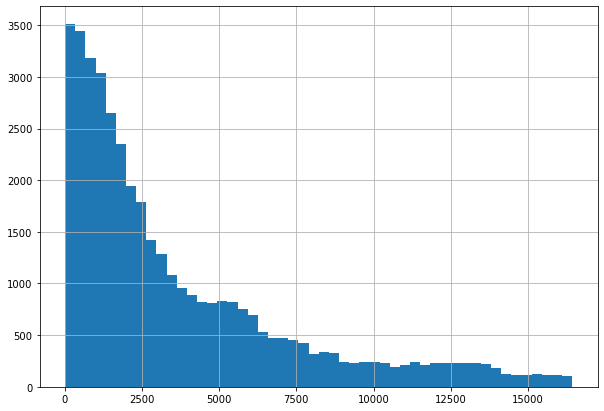

In [87]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=50)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

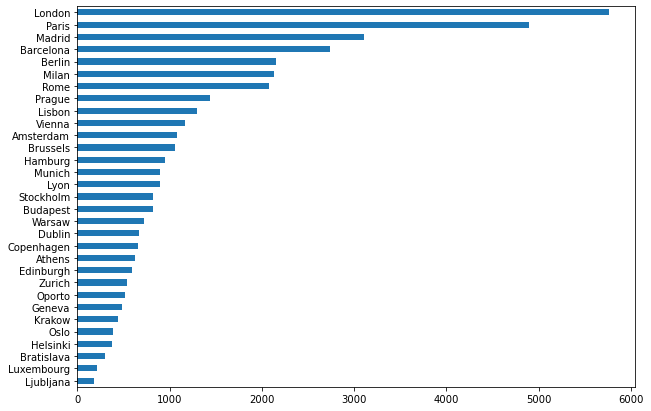

In [88]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

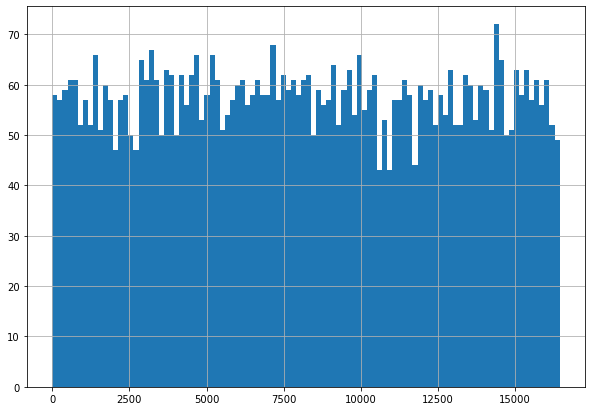

In [89]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

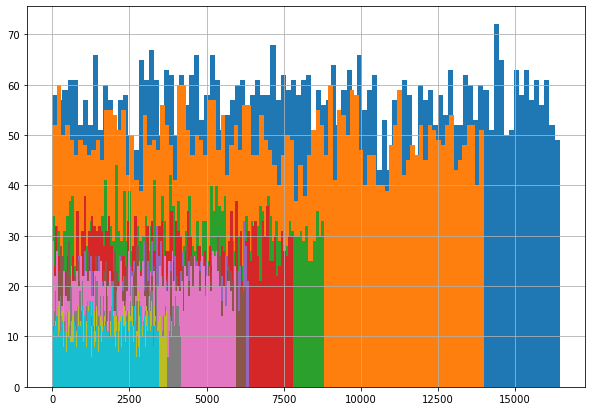

In [90]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

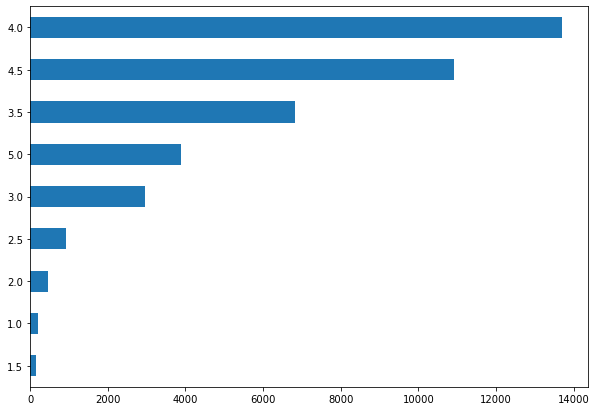

In [91]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

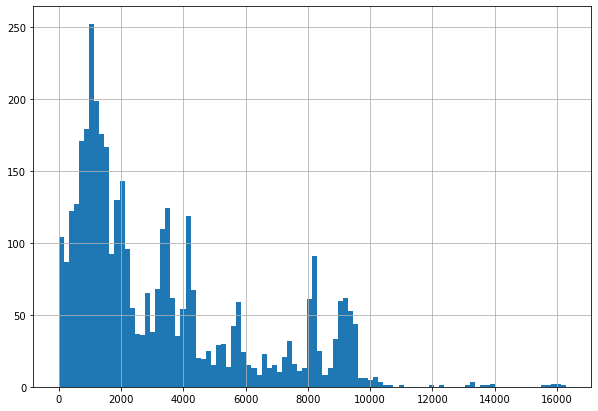

In [92]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

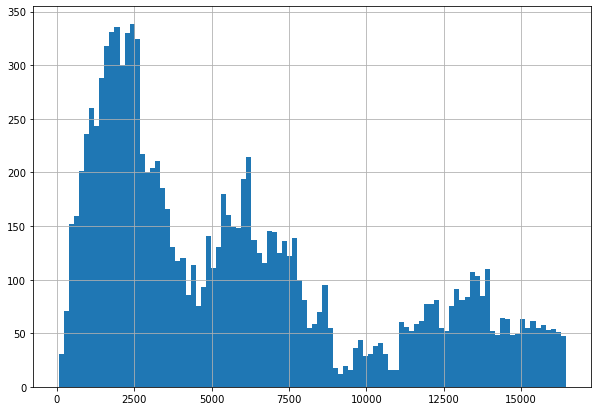

In [93]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Kорреляция признаков
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

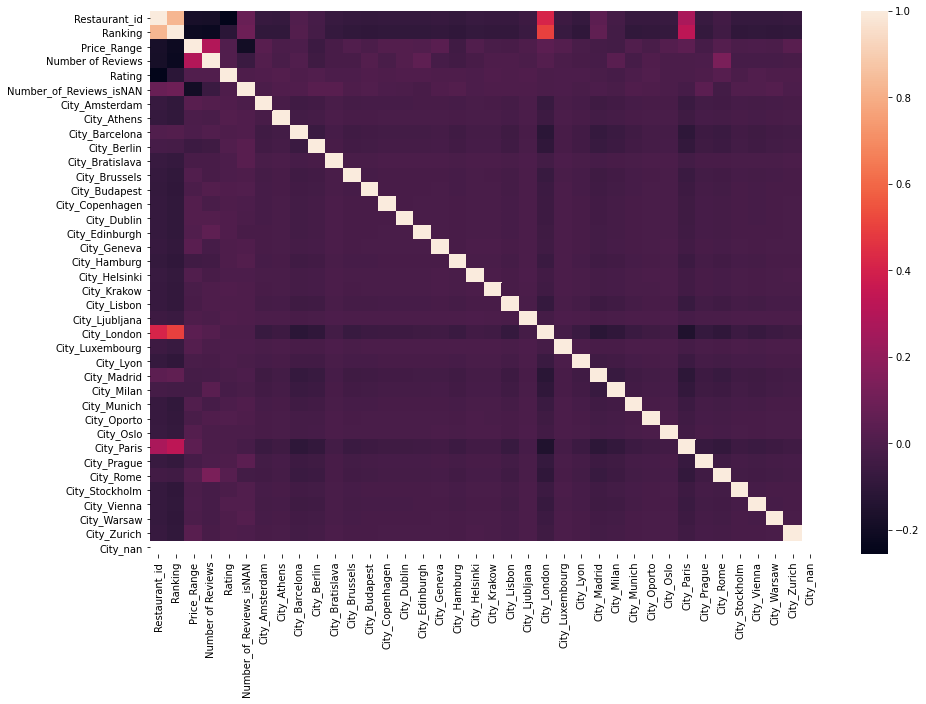

In [94]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

#### Посмотрим, какой вид кухни преобладает в датасете

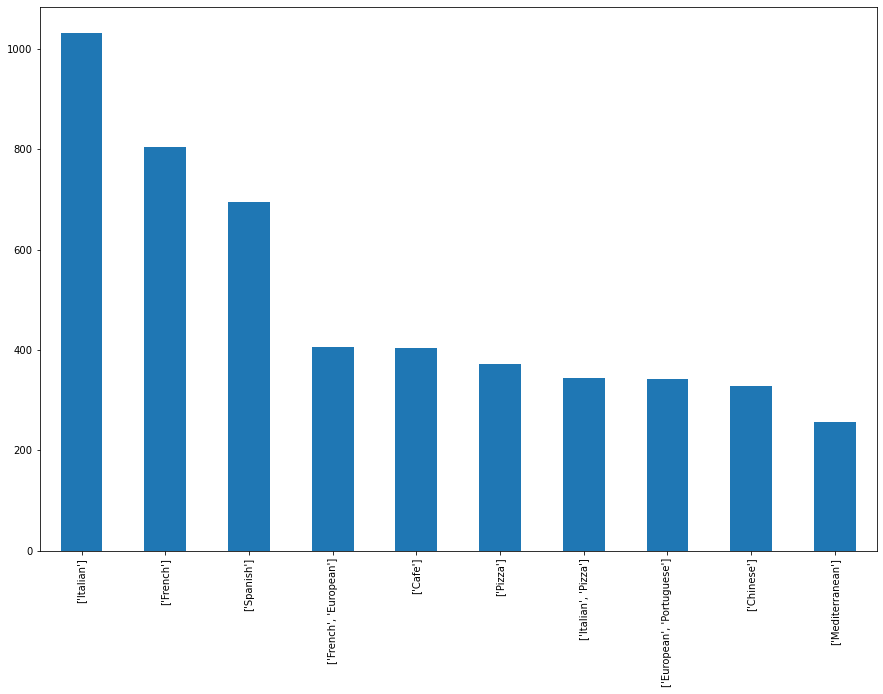

In [95]:
cuisine_style = df_train['Cuisine Style'].value_counts().head(10)
cuisine_style.plot.bar()

#### Как можно заметить, самая популярная Итальянская кухня

#### На графике выше мы видим 10 самых популярных видов кухни. Сделаем признак Popularity_сuisine. Если ресторан входит в эту десятку видов кухонь, то присвоем ему единицу, иначе 0.

In [96]:
df1.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 164 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Stockholm           50000 non-null  uint8  
 1   City_Vienna              50000 non-null  uint8  
 2   City_Warsaw              50000 non-null  uint8  
 3   City_Zurich              50000 non-null  uint8  
 4   City_nan                 50000 non-null  uint8  
 5   Restaurant_id            50000 non-null  int64  
 6   Price_Range              50000 non-null  int64  
 7   Number of Reviews        50000 non-null  float64
 8   sample                   50000 non-null  int64  
 9   Rating                   50000 non-null  float64
 10  Number_of_Reviews_isNAN  50000 non-null  uint8  
 11  City_Amsterdam           50000 non-null  uint8  
 12  City_Athens              50000 non-null  uint8  
 13  City_Barcelona           50000 non-null  uint8  
 14  City_Berlin          

In [97]:
df1['Italian'].value_counts()

0    42567
1     7433
Name: Italian, dtype: int64

In [98]:
def there_is(x):
    if (x==1):
        return 1 
    


In [99]:
#df1['Popularity_сuisine'].fillna(0, inplace=True)

In [100]:
df1['Popularity_сuisine']=df1.apply(lambda x: there_is(x['Italian']), axis=1 )
df1['Popularity_сuisine']=df1.apply(lambda x: there_is(x['French']), axis=1 )
df1['Popularity_сuisine']=df1.apply(lambda x: there_is(x['Cafe']), axis=1 )
df1['Popularity_сuisine']=df1.apply(lambda x: there_is(x['Pizza']), axis=1 )
df1['Popularity_сuisine']=df1.apply(lambda x: there_is(x['European']), axis=1 )
df1['Popularity_сuisine']=df1.apply(lambda x: there_is(x['Portuguese']), axis=1 )
df1['Popularity_сuisine']=df1.apply(lambda x: there_is(x['Chinese']), axis=1 )
df1['Popularity_сuisine']=df1.apply(lambda x: there_is(x['Mediterranean']), axis=1 )

In [101]:
df1['Popularity_сuisine'].fillna(0, inplace=True)

In [102]:
df1['Popularity_сuisine'].value_counts()
        

0.0    42180
1.0     7820
Name: Popularity_сuisine, dtype: int64

In [103]:
df1

,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Restaurant_id,Price_Range,Number of Reviews,sample,Rating,...,Italian,Mediterranean,other_cuisines,European,Vegetarian Friendly,City_Oslo,City_Paris,City_Prague,City_Rome,Popularity_сuisine
0,0,0,0,0,0,0,2,4.0,0,0.0,...,0,0,0,0,0,0,1,0,0,0.0
1,0,0,0,0,0,1,2,97.0,0,0.0,...,0,0,0,1,1,0,0,0,0,0.0
2,0,0,0,0,0,2,2,28.0,0,0.0,...,0,0,0,0,1,0,0,0,0,0.0
3,0,0,0,0,0,3,3,202.0,0,0.0,...,1,1,0,1,1,0,0,0,0,1.0
4,0,0,0,0,0,4,3,162.0,0,0.0,...,1,1,0,1,1,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,499,2,79.0,1,4.5,...,1,0,0,0,1,0,0,0,0,0.0
49996,0,0,0,0,0,6340,2,542.0,1,3.5,...,0,0,0,1,1,0,1,0,0,0.0
49997,1,0,0,0,0,1649,1,4.0,1,4.5,...,0,0,0,0,0,0,0,0,0,0.0
49998,0,0,1,0,0,640,2,70.0,1,4.0,...,0,0,0,1,1,0,0,0,0,0.0


#### Также добавим столбец Popularity_сity, где обозначим 1 города с наибольшим количеством ресторанов, 0 остальные

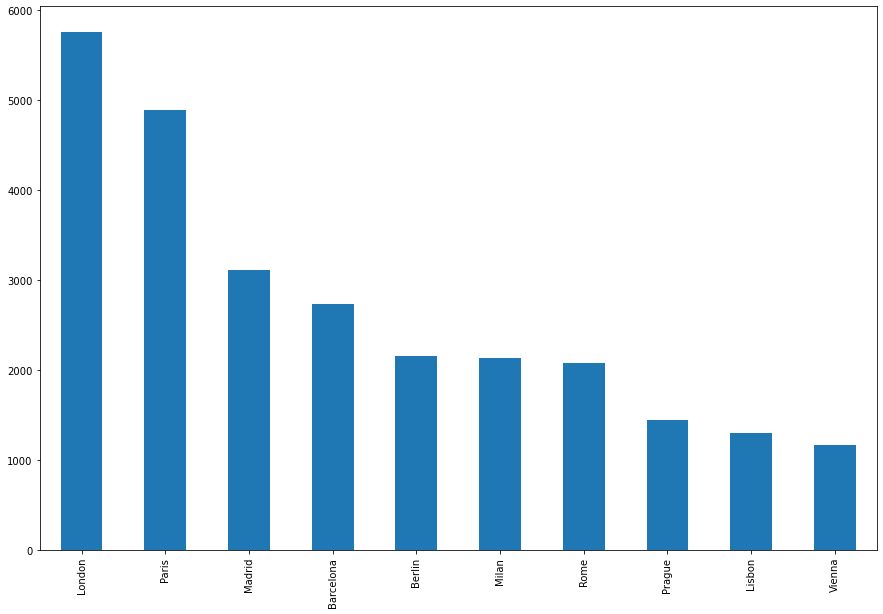

In [104]:
cuisine_style = df_train['City'].value_counts().head(10)
cuisine_style.plot.bar()

In [105]:
df_train['City'].value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

In [106]:
df1['Popularity_сity']=df1.apply(lambda x: there_is(x['City_London']), axis=1 )
df1['Popularity_сity']=df1.apply(lambda x: there_is(x['City_Paris']), axis=1 )
df1['Popularity_сity']=df1.apply(lambda x: there_is(x['City_Madrid']), axis=1 )
df1['Popularity_сity']=df1.apply(lambda x: there_is(x['City_Barcelona']), axis=1 )
df1['Popularity_сity']=df1.apply(lambda x: there_is(x['City_Berlin']), axis=1 )
df1['Popularity_сity']=df1.apply(lambda x: there_is(x['City_Milan']), axis=1 )
df1['Popularity_сity']=df1.apply(lambda x: there_is(x['City_Rome']), axis=1 )
df1['Popularity_сity']=df1.apply(lambda x: there_is(x['City_Prague']), axis=1 )
df1['Popularity_сity']=df1.apply(lambda x: there_is(x['City_Lisbon']), axis=1 )
df1['Popularity_сity']=df1.apply(lambda x: there_is(x['City_Vienna']), axis=1 )

In [107]:
df1['Popularity_сity'].fillna(0, inplace=True)

In [108]:
df1['Popularity_сity'].value_counts()

0.0    48557
1.0     1443
Name: Popularity_сity, dtype: int64

In [109]:
df1.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 166 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Stockholm           50000 non-null  uint8  
 1   City_Vienna              50000 non-null  uint8  
 2   City_Warsaw              50000 non-null  uint8  
 3   City_Zurich              50000 non-null  uint8  
 4   City_nan                 50000 non-null  uint8  
 5   Restaurant_id            50000 non-null  int64  
 6   Price_Range              50000 non-null  int64  
 7   Number of Reviews        50000 non-null  float64
 8   sample                   50000 non-null  int64  
 9   Rating                   50000 non-null  float64
 10  Number_of_Reviews_isNAN  50000 non-null  uint8  
 11  City_Amsterdam           50000 non-null  uint8  
 12  City_Athens              50000 non-null  uint8  
 13  City_Barcelona           50000 non-null  uint8  
 14  City_Berlin          

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [110]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')


df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [111]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['ID_TA','URL_TA'], axis = 1, inplace=True)
    RANDOM_SEED = 42
    def str_to_list(string):
        symbol_list = ['[',']',"'"]
    
        if string != None:
            for i in symbol_list:
                string = str(string).replace(i,'')
            return string.split(', ')
        return string
    
    def enumrate(string, nan_num):
        if string == nan_num:
            return nan_num
        else:
            if string.count('$') == 1:
                return 1
            elif string.count('$') == 5:
                return 2
            else:
                return 3
    
    def to_numeric(columns):
        s = pd.Series(df_output[columns])
        pd.to_numeric(s)
        df_output[columns] = pd.to_numeric(df_output[columns])
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    rank1=[]
    rank2=[]
    rank3=[]
    for rank in df_output['Ranking']:
        if ((rank>-15.5) and (rank<=5482)):
            rank1.append(rank)
        elif ((rank>5482) and (rank<=10963)):
            rank2.append(rank)
        elif ((rank>10963) and (rank<=16444)):
            rank3.append(rank)
            
    for rank in df_output['Ranking']:
        if ((rank<=5482)):
            df_output['Number of Reviews'].fillna(df_rank1['Number of Reviews'].mean(), inplace=True)
        elif ((rank>5482) and (rank<=10963)):
            df_output['Number of Reviews'].fillna(df_rank2['Number of Reviews'].mean(), inplace=True)
        elif ((rank<=16444)):
            df_output['Number of Reviews'].fillna(df_rank3['Number of Reviews'].mean(), inplace=True)
       
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('other_cuisines')

    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
       
    df_output.loc[df_output['Price Range'] == '$', 'Price Range'] = 1
    df_output.loc[df_output['Price Range'] == '$$ - $$$', 'Price Range'] = 2
    df_output.loc[df_output['Price Range'] == '$$$$', 'Price Range'] = 3
    
    df_output['Price Range'].fillna(0, inplace = True)
    df_output['Reviews'].fillna('[]', inplace = True)
    
    for i in df_output['Number of Reviews']:
        if (i<=3221.333):
            df_output.loc[df_output['Price Range'] == 0, 'Price Range'] = 1
        elif ((i>3221.333) and (i<=6440.667)):
            df_output.loc[df_output['Price Range'] == 0, 'Price Range'] = 2
        elif (i>6440.667):
            df_output.loc[df_output['Price Range'] == 0, 'Price Range'] = 3
    
    for col in ['Price Range']:
        to_numeric(col)
    
    df_output.Restaurant_id=df_output.Restaurant_id.apply(lambda x: x.replace('id_', ""))
    to_numeric('Restaurant_id')
    df_output = df_output.drop('Ranking', 1)

    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('other_cuisines').apply(str_to_list)
    
    cuisines_list = []
    for c_list in df_output['Cuisine Style']:
        for cus in c_list:
            cuisines_list.append(cus)
    
    cus_freq = pd.Series(cuisines_list).value_counts()
    cus_list = cus_freq.index
    print(cus_list, "last list bitch")
    
    for i in cus_list:
        df_output.insert(len(df_output.columns),i,0)
    
    for i in df_output['Cuisine Style'].index:
        Cus_style_value = df_output['Cuisine Style'][i]    
        for j in Cus_style_value:
            df_output[j][i] = 1
    
    #df_output['Price Range'] = df_output['Price Range'].apply(lambda x: enumrate(x,0))
    
    
    
    # ################### 4. Feature Engineering ####################################################

    rev = df_output['Reviews'].apply(lambda x: re.findall(r"'(\d+\/\d+\/\d+)'", x))
    dt_obj_list = [[dt.datetime.strptime(y, '%m/%d/%Y') for y in x] for x in rev]
    num_of_dates = pd.Series([len(x) for x in dt_obj_list])
    result_date = [max(x) if len(x) > 0 else 0 for x in dt_obj_list]
    result_year = pd.Series([x.year if isinstance(x, dt.datetime) else x for x in result_date])
    result_season = pd.Series([x.month%12//3 +1 if isinstance(x, dt.datetime) else x for x in result_date])
    result_weekend = pd.Series([(x.weekday() // 5) + 1 if isinstance(x, dt.datetime) else x for x in result_date])
        
    df_output.insert(4,'year',result_year)
    df_output.insert(5,'season',result_season)
    df_output.insert(6,'weekend',result_weekend)    
    df_output.insert(4,'number of dates',num_of_dates)
    
    def there_is(x):
        if (x==1):
            return 1 
        
    df_output['Popularity_сuisine']=df_output.apply(lambda x: there_is(x['Italian']), axis=1 )
    df_output['Popularity_сuisine']=df_output.apply(lambda x: there_is(x['French']), axis=1 )
    df_output['Popularity_сuisine']=df_output.apply(lambda x: there_is(x['Cafe']), axis=1 )
    df_output['Popularity_сuisine']=df_output.apply(lambda x: there_is(x['Pizza']), axis=1 )
    df_output['Popularity_сuisine']=df_output.apply(lambda x: there_is(x['European']), axis=1 )
    df_output['Popularity_сuisine']=df_output.apply(lambda x: there_is(x['Portuguese']), axis=1 )
    df_output['Popularity_сuisine']=df_output.apply(lambda x: there_is(x['Chinese']), axis=1 )
    df_output['Popularity_сuisine']=df_output.apply(lambda x: there_is(x['Mediterranean']), axis=1 )
    
    df_output['Popularity_сuisine'].fillna(0, inplace=True)
    
    df_output['Popularity_сity']=df_output.apply(lambda x: there_is(x['City_London']), axis=1 )
    df_output['Popularity_сity']=df_output.apply(lambda x: there_is(x['City_Paris']), axis=1 )
    df_output['Popularity_сity']=df_output.apply(lambda x: there_is(x['City_Madrid']), axis=1 )
    df_output['Popularity_сity']=df_output.apply(lambda x: there_is(x['City_Barcelona']), axis=1 )
    df_output['Popularity_сity']=df_output.apply(lambda x: there_is(x['City_Berlin']), axis=1 )
    df_output['Popularity_сity']=df_output.apply(lambda x: there_is(x['City_Milan']), axis=1 )
    df_output['Popularity_сity']=df_output.apply(lambda x: there_is(x['City_Rome']), axis=1 )
    df_output['Popularity_сity']=df_output.apply(lambda x: there_is(x['City_Prague']), axis=1 )
    df_output['Popularity_сity']=df_output.apply(lambda x: there_is(x['City_Lisbon']), axis=1 )
    df_output['Popularity_сity']=df_output.apply(lambda x: there_is(x['City_Vienna']), axis=1 )
    
    df_output['Popularity_сity'].fillna(0, inplace=True)
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output
    

#### Запускаем и проверяем что получилось

In [112]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

Index(['Vegetarian Friendly', 'European', 'other_cuisines', 'Mediterranean',
       'Italian', 'Vegan Options', 'Gluten Free Options', 'Bar', 'French',
       'Asian',
       ...
       'Caucasian', 'Azerbaijani', 'Welsh', 'Fujian', 'Polynesian', 'Yunnan',
       'Salvadoran', 'Burmese', 'Latvian', 'Xinjiang'],
      dtype='object', length=126) last list bitch


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Restaurant_id,Price Range,Number of Reviews,number of dates,year,season,weekend,sample,Rating,City_Amsterdam,...,Welsh,Fujian,Polynesian,Yunnan,Salvadoran,Burmese,Latvian,Xinjiang,Popularity_сuisine,Popularity_сity
9121,9121,1,3.0,2,2017,3,1,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
39977,6297,1,10.0,0,0,0,0,1,4.5,0,...,0,0,0,0,0,0,0,0,0.0,0.0
6058,6058,1,5.0,0,0,0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
18888,968,1,15.0,2,2017,3,1,1,4.0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
22141,5685,1,2.0,0,0,0,0,1,4.0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
1138,1138,1,28.0,2,2017,3,1,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
43878,3984,1,12.0,2,2017,2,1,1,5.0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
18381,7473,1,7.0,0,0,0,0,1,3.5,0,...,0,0,0,0,0,0,0,0,0.0,0.0
28625,3689,1,22.0,1,2017,1,1,1,4.0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
7627,7627,2,128.0,2,2017,1,1,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,0.0


In [113]:
df_preproc.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 169 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant_id        50000 non-null  int64  
 1   Price Range          50000 non-null  int64  
 2   Number of Reviews    50000 non-null  float64
 3   number of dates      50000 non-null  int64  
 4   year                 50000 non-null  int64  
 5   season               50000 non-null  int64  
 6   weekend              50000 non-null  int64  
 7   sample               50000 non-null  int64  
 8   Rating               50000 non-null  float64
 9   City_Amsterdam       50000 non-null  uint8  
 10  City_Athens          50000 non-null  uint8  
 11  City_Barcelona       50000 non-null  uint8  
 12  City_Berlin          50000 non-null  uint8  
 13  City_Bratislava      50000 non-null  uint8  
 14  City_Brussels        50000 non-null  uint8  
 15  City_Budapest        50000 non-null

In [114]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [115]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [116]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 168), (40000, 168), (40000, 167), (32000, 167), (8000, 167))

# Model 
Сам ML

In [117]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [118]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [119]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [120]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20748375


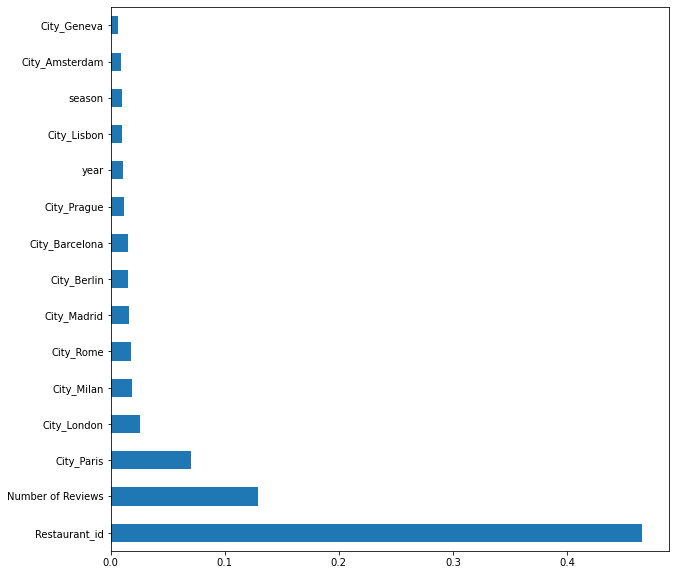

In [121]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [122]:
test_data.sample(10)

,Restaurant_id,Price Range,Number of Reviews,number of dates,year,season,weekend,Rating,City_Amsterdam,City_Athens,...,Welsh,Fujian,Polynesian,Yunnan,Salvadoran,Burmese,Latvian,Xinjiang,Popularity_сuisine,Popularity_сity
8758,8758,1,6.0,2,2017,1,1,0.0,0,1,...,0,0,0,0,0,0,0,0,0.0,0.0
6610,6610,2,15.0,2,2017,4,2,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
6129,6129,2,35.0,1,2017,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
8995,8995,1,16.0,0,0,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
702,702,1,42.0,2,2018,1,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2958,2958,2,59.0,2,2017,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2399,2399,2,752.0,2,2018,1,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
4171,4171,2,5.0,1,2017,1,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
9462,9462,2,67.0,2,2016,1,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
153,153,1,2.0,2,2017,2,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0


In [123]:
test_data = test_data.drop(['Rating'], axis=1)

In [124]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [125]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [126]:
predict_submission

array([4.91 , 4.605, 4.86 , ..., 1.005, 1.005, 3.8  ])

In [127]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,4.910
1,id_1,4.605
2,id_2,4.860
3,id_3,4.735
4,id_4,4.710
5,id_5,4.770
6,id_6,4.910
7,id_7,4.885
8,id_8,4.820
9,id_9,4.785


In [128]:
#kaggle competitions submit -c sf-dst-restaurant-rating -f submission.csv